# Train a Semantic Segmentation Model using Segmentation-Models-PyTorch

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/geoai/blob/main/docs/examples/train_segmentation_model.ipynb)

This notebook demonstrates how to train semantic segmentation models for object detection (e.g., building detection) using the [segmentation-models-pytorch](https://smp.readthedocs.io) library. Unlike instance segmentation with Mask R-CNN, this approach treats the task as pixel-level binary classification.

## Install packages
To use the new functionality, ensure the required packages are installed.


In [1]:
%pip install geoai-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.1/568.1 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88

## Import libraries

In [2]:
import geoai

## Download sample data

We'll use the same dataset as the Mask R-CNN example for consistency.

In [3]:
train_raster_url = (
    "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip_rgb_train.tif"
)
train_vector_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip_train_buildings.geojson"
test_raster_url = (
    "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip_test.tif"
)

In [4]:
train_raster_path = geoai.download_file(train_raster_url)
train_vector_path = geoai.download_file(train_vector_url)
test_raster_path = geoai.download_file(test_raster_url)

naip_rgb_train.tif: 100%|██████████| 8.88M/8.88M [00:00<00:00, 71.0MB/s]
naip_train_buildings.geojson: 334kB [00:00, 23.6MB/s]
naip_test.tif: 100%|██████████| 19.7M/19.7M [00:00<00:00, 75.2MB/s]


## Visualize sample data

In [5]:
geoai.get_raster_info(train_raster_path)

{'driver': 'GTiff',
 'width': 2503,
 'height': 1126,
 'count': 3,
 'dtype': 'uint8',
 'crs': 'EPSG:26911',
 'transform': Affine(0.6000000000000046, 0.0, 454780.8,
        0.0, -0.6, 5278242.6),
 'bounds': BoundingBox(left=454780.8, bottom=5277567.0, right=456282.6, top=5278242.6),
 'resolution': (0.6000000000000046, 0.6),
 'nodata': None,
 'band_stats': [{'band': 1,
   'min': 12.0,
   'max': 251.0,
   'mean': 150.6730747259594,
   'std': 48.01908734374099},
  {'band': 2,
   'min': 49.0,
   'max': 251.0,
   'mean': 141.92468895229808,
   'std': 43.46595463573497},
  {'band': 3,
   'min': 53.0,
   'max': 251.0,
   'mean': 120.89909373405554,
   'std': 41.78086244480775}]}

In [6]:
geoai.view_vector_interactive(train_vector_path, tiles=train_raster_url)

In [7]:
geoai.view_raster(test_raster_url)

## Create training data

We'll create the same training tiles as before.

In [8]:
out_folder = "buildings"
tiles = geoai.export_geotiff_tiles(
    in_raster=train_raster_path,
    out_folder=out_folder,
    in_class_data=train_vector_path,
    tile_size=512,
    stride=256,
    buffer_radius=0,
)


Raster info for naip_rgb_train.tif:
  CRS: EPSG:26911
  Dimensions: 2503 x 1126
  Resolution: (0.6000000000000046, 0.6)
  Bands: 3
  Bounds: BoundingBox(left=454780.8, bottom=5277567.0, right=456282.6, top=5278242.6)
Loaded 735 features from naip_train_buildings.geojson
Vector CRS: EPSG:4326
Reprojecting features from EPSG:4326 to EPSG:26911
Found 1 unique classes: ['building']


Generated: 36, With features: 36: 100%|██████████| 36/36 [00:09<00:00,  3.85it/s]


------- Export Summary -------
Total tiles exported: 36
Tiles with features: 36 (100.0%)
Average feature pixels per tile: 46795.0
Output saved to: buildings

------- Georeference Verification -------


## Train semantic segmentation model

Now we'll train a semantic segmentation model using the new `train_segmentation_model` function. This function supports various architectures from `segmentation-models-pytorch`:

- **Architectures**: `unet`, `unetplusplus` `deeplabv3`, `deeplabv3plus`, `fpn`, `pspnet`, `linknet`, `manet`
- **Encoders**: `resnet34`, `resnet50`, `efficientnet-b0`, `mobilenet_v2`, etc.

For more details, please refer to the [segmentation-models-pytorch documentation](https://smp.readthedocs.io/en/latest/models.html).

### Example 1: U-Net with ResNet34 encoder


In [9]:
# Train U-Net model
geoai.train_segmentation_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/unet_models",
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    num_channels=3,
    num_classes=2,  # background and building
    batch_size=8,
    num_epochs=100,
    learning_rate=0.001,
    val_split=0.2,
    verbose=True,
)

Using device: cuda
Found 36 image files and 36 label files
Training on 28 images, validating on 8 images


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Starting training with unet + resnet34
Model parameters: 24,436,514
Epoch: 0, Batch: 0/4, Loss: 0.6278, Time: 1.88s
Epoch 1/100: Train Loss: 0.4977, Val Loss: 1.9756, Val IoU: 0.4171, Val Dice: 0.4547
Saving best model with IoU: 0.4171
Epoch: 1, Batch: 0/4, Loss: 0.3396, Time: 1.04s
Epoch 2/100: Train Loss: 0.2994, Val Loss: 7.3538, Val IoU: 0.4466, Val Dice: 0.5084
Saving best model with IoU: 0.4466
Epoch: 2, Batch: 0/4, Loss: 0.1919, Time: 1.06s
Epoch 3/100: Train Loss: 0.1892, Val Loss: 11.1599, Val IoU: 0.4179, Val Dice: 0.4560
Epoch: 3, Batch: 0/4, Loss: 0.1643, Time: 1.22s
Epoch 4/100: Train Loss: 0.1451, Val Loss: 0.8867, Val IoU: 0.4891, Val Dice: 0.6280
Saving best model with IoU: 0.4891
Epoch: 4, Batch: 0/4, Loss: 0.1268, Time: 1.00s
Epoch 5/100: Train Loss: 0.1238, Val Loss: 1.2127, Val IoU: 0.6257, Val Dice: 0.7277
Saving best model with IoU: 0.6257
Epoch: 5, Batch: 0/4, Loss: 0.1082, Time: 0.91s
Epoch 6/100: Train Loss: 0.1123, Val Loss: 0.2886, Val IoU: 0.7637, Val Dice: 

### Example 2: SegFormer with resnet152 encoder

In [10]:
geoai.train_segmentation_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/segformer_models",
    architecture="segformer",
    encoder_name="resnet152",
    encoder_weights="imagenet",
    num_channels=3,
    num_classes=2,
    batch_size=6,  # Smaller batch size for more complex model
    num_epochs=50,
    learning_rate=0.0005,
    val_split=0.2,
)

Using device: cuda
Found 36 image files and 36 label files
Training on 28 images, validating on 8 images


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Starting training with segformer + resnet152
Model parameters: 59,473,218
Epoch: 0, Batch: 0/5, Loss: 0.8009, Time: 1.74s
Epoch 1/50: Train Loss: 0.6948, Val Loss: 7.3512, Val IoU: 0.1171, Val Dice: 0.2026
Saving best model with IoU: 0.1171
Epoch: 1, Batch: 0/5, Loss: 0.3487, Time: 1.56s
Epoch 2/50: Train Loss: 0.2926, Val Loss: 0.8011, Val IoU: 0.5022, Val Dice: 0.6360
Saving best model with IoU: 0.5022
Epoch: 2, Batch: 0/5, Loss: 0.2075, Time: 1.46s
Epoch 3/50: Train Loss: 0.1846, Val Loss: 0.3212, Val IoU: 0.5891, Val Dice: 0.7038
Saving best model with IoU: 0.5891
Epoch: 3, Batch: 0/5, Loss: 0.1468, Time: 1.43s
Epoch 4/50: Train Loss: 0.1419, Val Loss: 0.2226, Val IoU: 0.7237, Val Dice: 0.8268
Saving best model with IoU: 0.7237
Epoch: 4, Batch: 0/5, Loss: 0.1386, Time: 1.44s
Epoch 5/50: Train Loss: 0.1268, Val Loss: 0.1731, Val IoU: 0.7876, Val Dice: 0.8749
Saving best model with IoU: 0.7876
Epoch: 5, Batch: 0/5, Loss: 0.1070, Time: 1.36s
Epoch 6/50: Train Loss: 0.1145, Val Loss: 0

## Run inference

Now we'll use the trained model to make predictions on the test image.

In [11]:
# Define paths
masks_path = "naip_test_semantic_prediction.tif"
model_path = f"{out_folder}/unet_models/best_model.pth"

In [12]:
# Run semantic segmentation inference
geoai.semantic_segmentation(
    input_path=test_raster_path,
    output_path=masks_path,
    model_path=model_path,
    architecture="unet",
    encoder_name="resnet34",
    num_channels=3,
    num_classes=2,
    window_size=512,
    overlap=256,
    batch_size=4,
)

Processing 65 windows...


84it [00:02, 39.37it/s]


Predicted classes: 2 classes, Background: 87.9%
Inference completed in 2.69 seconds
Saved prediction to naip_test_semantic_prediction.tif


## Vectorize masks

Convert the predicted mask to vector format for better visualization and analysis.

In [13]:
output_vector_path = "naip_test_semantic_prediction.geojson"
gdf = geoai.orthogonalize(masks_path, output_vector_path, epsilon=2)

Processing 1446 features...


Converting features: 100%|██████████| 1446/1446 [00:12<00:00, 112.12shape/s]


Saving to naip_test_semantic_prediction.geojson...
Done!


## Add geometric properties

In [14]:
gdf_props = geoai.add_geometric_properties(gdf, area_unit="m2", length_unit="m")

## Visualize results

In [15]:
geoai.view_raster(masks_path, nodata=0, basemap=test_raster_url, backend="ipyleaflet")

Map(center=[47.6464835, -117.59043650000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In [16]:
geoai.view_vector_interactive(gdf_props, column="area_m2", tiles=test_raster_url)

In [17]:
gdf_filtered = gdf_props[(gdf_props["area_m2"] > 50)]

In [18]:
geoai.view_vector_interactive(gdf_filtered, column="area_m2", tiles=test_raster_url)

In [19]:
geoai.create_split_map(
    left_layer=gdf_filtered,
    right_layer=test_raster_url,
    left_args={"style": {"color": "red", "fillOpacity": 0.2}},
    basemap=test_raster_url,
)

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Model Performance Analysis

Let's examine the training curves and model performance:

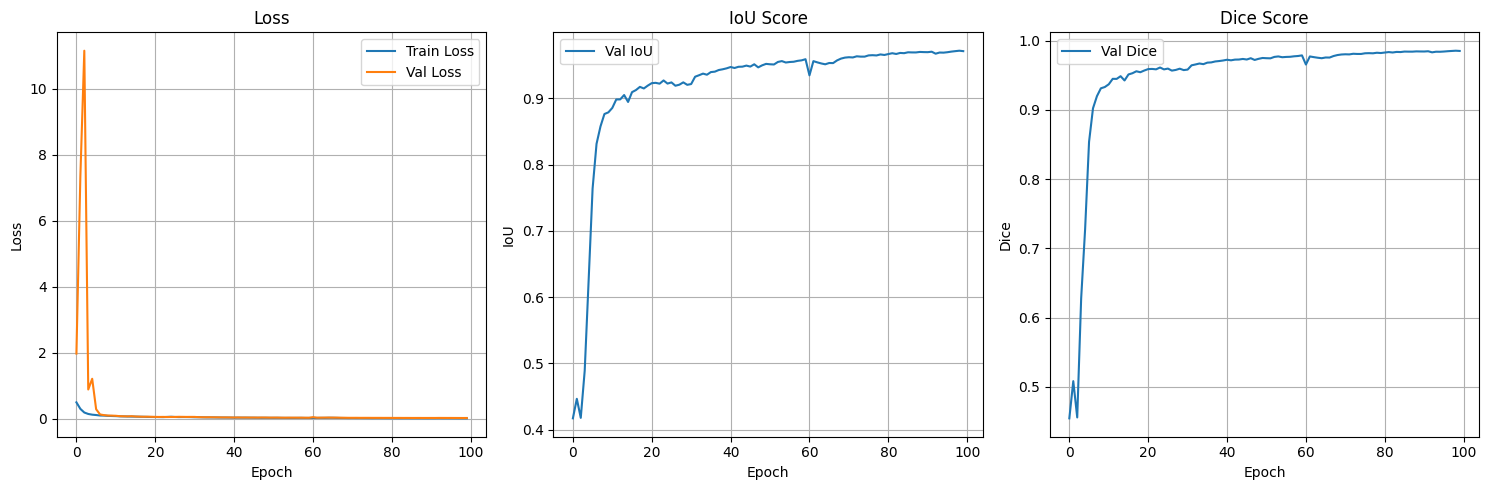

Best IoU: 0.9717
Best Dice: 0.9855
Final IoU: 0.9710
Final Dice: 0.9852


In [20]:
geoai.plot_performance_metrics(
    history_path=f"{out_folder}/unet_models/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)

![image](https://github.com/user-attachments/assets/9355446f-f9ba-4818-aedb-4bb5dee56813)

## Performance Metrics

**IoU (Intersection over Union)** and **Dice score** are both popular metrics used to evaluate the similarity between two binary masks—often in image segmentation tasks. While they are related, they are not the same.

---

### 🔸 **Definitions**

#### **IoU (Jaccard Index)**

$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|}
$$

* Measures the overlap between predicted region $A$ and ground truth region $B$ relative to their union.
* Ranges from 0 (no overlap) to 1 (perfect overlap).

#### **Dice Score (F1 Score for Sets)**

$$
\text{Dice} = \frac{2|A \cap B|}{|A| + |B|}
$$

* Measures the overlap between $A$ and $B$, but gives more weight to the intersection.
* Also ranges from 0 to 1.

---

### 🔸 **Key Differences**

| Metric   | Formula                     | Penalizes                      | Sensitivity                      |
| -------- | --------------------------- | ------------------------------ | -------------------------------- |
| **IoU**  | $\frac{TP}{TP + FP + FN}$   | FP and FN equally              | Less sensitive to small objects  |
| **Dice** | $\frac{2TP}{2TP + FP + FN}$ | Less harsh on small mismatches | More sensitive to small overlaps |

> TP: True Positive, FP: False Positive, FN: False Negative

---

### 🔸 **Relationship**

Dice and IoU are mathematically related:

$$
\text{Dice} = \frac{2 \cdot \text{IoU}}{1 + \text{IoU}} \quad \text{or} \quad \text{IoU} = \frac{\text{Dice}}{2 - \text{Dice}}
$$

---

### 🔸 **When to Use What**

* **IoU**: Common in object detection and semantic segmentation benchmarks (e.g., COCO, Pascal VOC).
* **Dice**: Preferred in medical imaging and when class imbalance is an issue, due to its sensitivity to small regions.